In [1]:
# ============================================
# 📦 Step 1: Import Libraries
# ============================================

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'  # Suppress libpng ICC profile warnings

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import cv2
import random
from tqdm import tqdm
from pathlib import Path
import kagglehub

# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")
BASE_PATH = Path(path)
print(f"📂 Dataset path: {BASE_PATH}")

df = pd.read_csv(BASE_PATH / "Data_Entry_2017.csv")
images_dir = BASE_PATH / "images-224" / "images-224"
df["Image Path"] = [str(images_dir / p) for p in df["Image Index"].values]

DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Validate sample images
sample_paths = df['Image Path'].sample(200, random_state=42).values
missing = [p for p in sample_paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"❌ Missing {len(missing)} images! First 3: {missing[:3]}")

print(f"✅ Loaded {len(df):,} images")
print(f"📊 Disease categories: {len(DISEASE_CATEGORIES)}")

📂 Dataset path: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3
✅ Loaded 112,120 images
📊 Disease categories: 14


In [4]:
# ============================================
# ⚙️ Step 3: Configuration
# ============================================

class Config:
    # Model
    img_size = 224
    feat_dim = 256
    proj_dim = 128
    encoder_backbone = 'custom'  # 'custom' or 'mobilenet_v2'
    
    # Training
    batch_size = 32  # Reduced from 64 to avoid OOM
    pretrain_epochs = 30
    finetune_epochs = 60
    lr_pretrain = 5e-4
    lr_finetune = 5e-5
    temperature = 0.1
    mask_weight = 0.3  # Weight for mask-based loss modulation
    
    # Data
    num_workers = 4
    use_subset = False
    subset_size = 10000
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = Config()

# Memory optimization
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print("⚙️ Configuration:")
print(f"   Device: {cfg.device}")
print(f"   Batch size: {cfg.batch_size}")
print(f"   Encoder backbone: {cfg.encoder_backbone}")
print(f"   Mask weight: {cfg.mask_weight}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Resume configuration
RESUME_SSL_PRETRAINING = True
RESUME_FINETUNING = True
SSL_CHECKPOINT_FILE = 'latest'
FINETUNE_CHECKPOINT_FILE = 'latest'


⚙️ Configuration:
   Device: cuda
   Batch size: 32
   Encoder backbone: custom
   Mask weight: 0.3
   GPU: NVIDIA A100-SXM4-80GB
   GPU Memory: 85.0 GB


In [5]:
# ============================================
# 💾 Step 3.5: Checkpoint & Resume Configuration
# ============================================
# ⚠️ EDIT THIS SECTION WHEN RESUMING AFTER DAYS/WEEKS

import os
import shutil
from datetime import datetime

# ╔══════════════════════════════════════════════════════════════╗
# ║  🔧 RESUME CONFIGURATION - EDIT THESE VALUES WHEN RESUMING  ║
# ╚══════════════════════════════════════════════════════════════╝

# ===== STEP 1: Set your checkpoint dataset name =====
# After your first run, save outputs as dataset and put the name here
# ⚠️ Use the EXACT name (lowercase, hyphens) - check /kaggle/input/
CHECKPOINT_DATASET_NAME = "option1-ssl-checkpoints"  # Unique for Option 1

# ===== STEP 2: Set resume flags =====
RESUME_SSL_PRETRAINING = True    # Set True to resume SSL pretraining
RESUME_FINETUNING = True         # Set True to resume fine-tuning

# ===== STEP 3: If resuming, specify which checkpoint to load =====
# Leave as "latest" to auto-detect, or specify: "option1_ssl_epoch20.pth"
SSL_CHECKPOINT_FILE = "latest"
FINETUNE_CHECKPOINT_FILE = "latest"

# ╔══════════════════════════════════════════════════════════════╗
# ║                    END OF USER CONFIG                        ║
# ╚══════════════════════════════════════════════════════════════╝

# Detect environment
IN_KAGGLE = os.path.exists('/kaggle')

if IN_KAGGLE:
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    
    print("🔍 Scanning for checkpoint datasets...")
    print("="*60)
    
    # Load checkpoints from ALL versions of the dataset (v1, v2, v3, etc.)
    # This allows keeping older versions while adding new ones
    input_path = '/kaggle/input'
    if os.path.exists(input_path):
        found_any = False
        for dataset_folder in sorted(os.listdir(input_path)):
            # Match datasets starting with our checkpoint name (option-1, option-1-v2, etc.)
            if dataset_folder.startswith(CHECKPOINT_DATASET_NAME):
                dataset_path = os.path.join(input_path, dataset_folder)
                if os.path.isdir(dataset_path):
                    # Check for .pth files in multiple locations:
                    # 1. Directly in dataset folder
                    # 2. In 'checkpoints' subdirectory
                    # 3. In any subdirectory
                    search_paths = [dataset_path]
                    
                    # Add checkpoints subdirectory if it exists
                    checkpoints_subdir = os.path.join(dataset_path, 'checkpoints')
                    if os.path.isdir(checkpoints_subdir):
                        search_paths.append(checkpoints_subdir)
                    
                    # Also check any other subdirectories for .pth files
                    for item in os.listdir(dataset_path):
                        item_path = os.path.join(dataset_path, item)
                        if os.path.isdir(item_path) and item != 'checkpoints':
                            search_paths.append(item_path)
                    
                    for search_path in search_paths:
                        pth_files = [f for f in os.listdir(search_path) if f.endswith('.pth')]
                        if pth_files:
                            found_any = True
                            rel_path = os.path.relpath(search_path, input_path)
                            print(f"📂 Found checkpoints in: {rel_path}")
                            for f in pth_files:
                                src = os.path.join(search_path, f)
                                dst = os.path.join(CHECKPOINT_DIR, f)
                                if not os.path.exists(dst):
                                    shutil.copy2(src, dst)
                                    print(f"   📦 Copied: {f}")
                                else:
                                    # Check if source is newer
                                    src_time = os.path.getmtime(src)
                                    dst_time = os.path.getmtime(dst)
                                    if src_time > dst_time:
                                        shutil.copy2(src, dst)
                                        print(f"   🔄 Updated: {f} (newer version)")
        
        if not found_any:
            print(f"ℹ️ No checkpoint datasets found matching: {CHECKPOINT_DATASET_NAME}*")
            print("   This is normal for a fresh start!")
    
    existing = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
    print("="*60)
    if existing:
        print(f"✅ Total checkpoints available: {len(existing)}")
    else:
        print(f"ℹ️ Starting fresh - no checkpoints loaded")
        
else:\n
    CHECKPOINT_DIR = './checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===== CHECKPOINT UTILITIES =====
def save_checkpoint(state, filename):
    """Save checkpoint with timestamp"""
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    state['saved_at'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    torch.save(state, filepath)
    print(f"💾 Saved: {filename}")
    
    if IN_KAGGLE:
        # Also save to root /kaggle/working/ for easy access
        torch.save(state, f'/kaggle/working/{filename}')

def load_checkpoint(filename):
    """Load checkpoint from storage"""
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=cfg.device, weights_only=False)
        saved_at = checkpoint.get('saved_at', 'Unknown')
        print(f"✅ Loaded: {filename} (saved: {saved_at})")
        return checkpoint
    print(f"⚠️ Not found: {filepath}")
    return None

def find_latest_checkpoint(prefix):
    """Find the most recent checkpoint with given prefix"""
    if not os.path.exists(CHECKPOINT_DIR):
        return None
    
    # First check for 'latest' checkpoint
    latest_file = f'{prefix}_latest.pth'
    if os.path.exists(os.path.join(CHECKPOINT_DIR, latest_file)):
        return latest_file
    
    # Otherwise find highest epoch number
    import re
    pattern = re.compile(rf'{prefix}_epoch(\d+)\.pth')
    max_epoch = -1
    best_file = None
    
    for f in os.listdir(CHECKPOINT_DIR):
        match = pattern.match(f)
        if match:
            epoch = int(match.group(1))
            if epoch > max_epoch:
                max_epoch = epoch
                best_file = f
    
    return best_file

def list_checkpoints():
    """List all available checkpoints with details"""
    print(f"\n📁 Checkpoints in {CHECKPOINT_DIR}:")
    if not os.path.exists(CHECKPOINT_DIR):
        print("   (empty)")
        return []
    
    files = sorted([f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')])
    if not files:
        print("   (empty)")
        return []
    
    for f in files:
        filepath = os.path.join(CHECKPOINT_DIR, f)
        size = os.path.getsize(filepath) / (1024*1024)
        try:
            ckpt = torch.load(filepath, map_location='cpu', weights_only=False)
            epoch = ckpt.get('epoch', '?')
            saved_at = ckpt.get('saved_at', 'Unknown')
            print(f"   📦 {f} | Epoch {epoch} | {size:.1f}MB | {saved_at}")
        except:
            print(f"   📦 {f} | {size:.1f}MB")
    return files

def get_training_status():
    """Get current training progress"""
    ssl_ckpt = find_latest_checkpoint('option1_ssl')
    ft_ckpt = find_latest_checkpoint('option1_finetune')
    
    print("\n" + "="*60)
    print("📊 TRAINING STATUS")
    print("="*60)
    
    if ssl_ckpt:
        ckpt = torch.load(os.path.join(CHECKPOINT_DIR, ssl_ckpt), map_location='cpu', weights_only=False)
        ssl_epoch = ckpt.get('epoch', 0)
        print(f"SSL Pretraining: Epoch {ssl_epoch}/{cfg.pretrain_epochs} "
              f"({'COMPLETE ✅' if ssl_epoch >= cfg.pretrain_epochs else 'IN PROGRESS'})")
    else:
        print("SSL Pretraining: NOT STARTED")
        ssl_epoch = 0
    
    if ft_ckpt:
        ckpt = torch.load(os.path.join(CHECKPOINT_DIR, ft_ckpt), map_location='cpu', weights_only=False)
        ft_epoch = ckpt.get('epoch', 0)
        best_auc = ckpt.get('best_val_auc', 0)
        print(f"Fine-tuning: Epoch {ft_epoch}/{cfg.finetune_epochs} "
              f"({'COMPLETE ✅' if ft_epoch >= cfg.finetune_epochs else 'IN PROGRESS'})")
        print(f"Best Val AUC: {best_auc:.4f}")
    else:
        print("Fine-tuning: NOT STARTED")
    
    print("="*60)

# Show current status
print(f"\n🔧 Environment: {'Kaggle' if IN_KAGGLE else 'Local'}")
print(f"📂 Checkpoint directory: {CHECKPOINT_DIR}")
list_checkpoints()
get_training_status()

print("\n" + "="*60)
print("📌 SAVING & RESUMING WORKFLOW:")
print("="*60)
print(f"""
After each run on Kaggle:
  1. Click 'Save Version' → 'Quick Save'
  2. Go to Output tab → '+ New Dataset'
  3. Name it: {CHECKPOINT_DATASET_NAME}
     (Kaggle will auto-version: {CHECKPOINT_DATASET_NAME}, {CHECKPOINT_DATASET_NAME}-v2, etc.)

To resume in a NEW session:
  1. Click 'Add Input' (right panel)
  2. Select 'Your Datasets' → Add ALL versions of {CHECKPOINT_DATASET_NAME}
  3. Run notebook - it will automatically load the latest checkpoints!
""")
print("="*60)


🔧 Environment: Local
📂 Checkpoint directory: ./checkpoints

📁 Checkpoints in ./checkpoints:
   (empty)

📊 TRAINING STATUS
SSL Pretraining: NOT STARTED
Fine-tuning: NOT STARTED

📌 SAVING & RESUMING WORKFLOW:

After each run on Kaggle:
  1. Click 'Save Version' → 'Quick Save'
  2. Go to Output tab → '+ New Dataset'
  3. Name it: option1-ssl-checkpoints
     (Kaggle will auto-version: option1-ssl-checkpoints, option1-ssl-checkpoints-v2, etc.)

To resume in a NEW session:
  1. Click 'Add Input' (right panel)
  2. Select 'Your Datasets' → Add ALL versions of option1-ssl-checkpoints
  3. Run notebook - it will automatically load the latest checkpoints!



In [7]:
# ============================================
# Step 4: Load Pre-Computed Lung Masks
# ============================================
# Masks pre-computed by precompute_lung_masks.ipynb

if IN_KAGGLE:
    PIXEL_MASK_DIR = "/kaggle/working/lung_masks/pixel_masks"
else:
    PIXEL_MASK_DIR = "./lung_masks/pixel_masks"

def load_precomputed_mask(img_name, mask_dir=PIXEL_MASK_DIR, img_size=224):
    """Load pre-computed pixel-level lung mask from disk."""
    mask_name = img_name.replace(".png", "")
    mask = np.load(os.path.join(mask_dir, f"{mask_name}.npy"))
    if mask.dtype == np.uint8:
        mask = mask.astype(np.float32) / 255.0
    if mask.shape[0] != img_size or mask.shape[1] != img_size:
        mask = cv2.resize(mask, (img_size, img_size))
    return mask

print(f"Masks loaded from: {PIXEL_MASK_DIR}")
print(f"✅ Mask loader ready. Mask dir: {PIXEL_MASK_DIR}")


Masks loaded from: ./lung_masks/pixel_masks
  Test mask shape: (224, 224), coverage: 21.9%


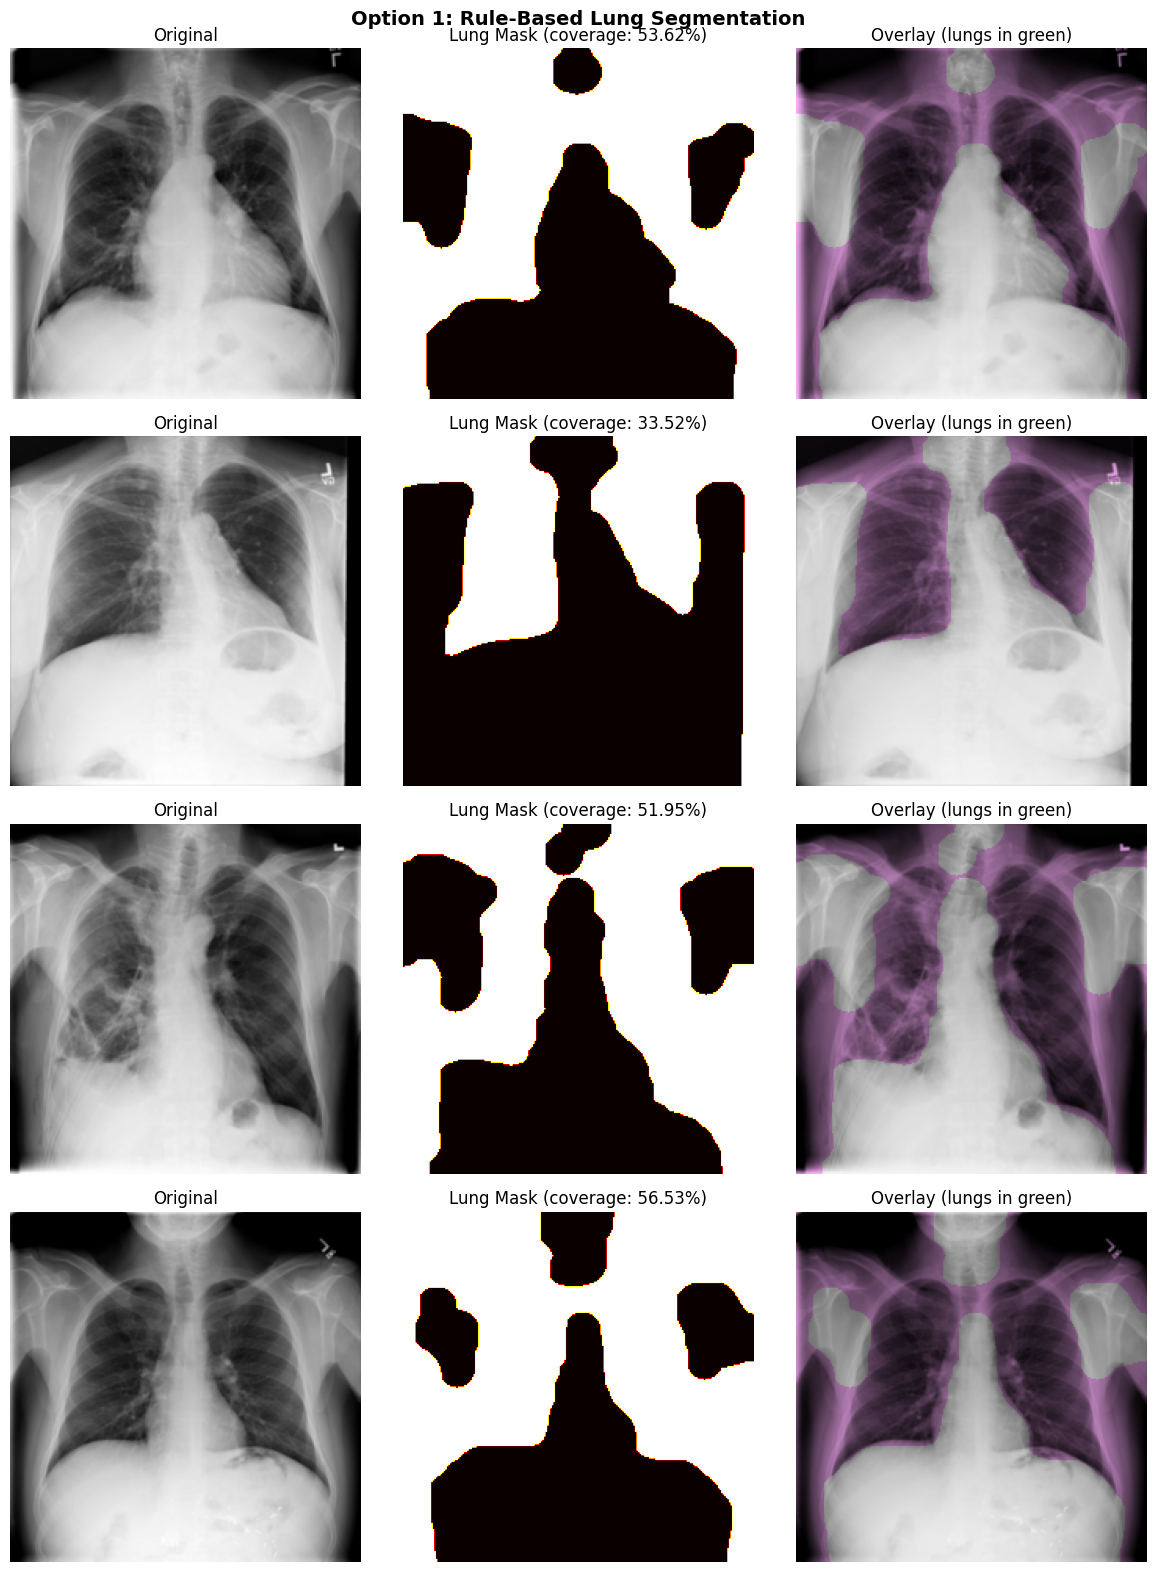

In [25]:
# ============================================
# 👁️ Step 5: Visualize Lung Segmentation
# ============================================

# Test segmentation on sample images
sample_indices = [0, 100, 500, 1000]
fig, axes = plt.subplots(len(sample_indices), 3, figsize=(12, 4*len(sample_indices)))

for i, idx in enumerate(sample_indices):
    img_path = df.iloc[idx]['Image Path']
    img = Image.open(img_path).convert('L')
    img = img.resize((cfg.img_size, cfg.img_size), Image.LANCZOS)
    img_np = np.array(img, dtype=np.float32) / 255.0
    
    # Get segmentation
    img_name = df.iloc[idx]["Image Index"]
    mask = load_precomputed_mask(img_name)
    
    # Plot
    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='hot')
    axes[i, 1].set_title(f'Lung Mask (coverage: {mask.mean():.2%})')
    axes[i, 1].axis('off')
    
    # Overlay
    overlay = np.stack([img_np * (1 - 0.3*mask), img_np, img_np * (1 - 0.3*mask)], axis=-1)
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay (lungs in green)')
    axes[i, 2].axis('off')

plt.suptitle('Option 1: Rule-Based Lung Segmentation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option1_segmentation_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# ============================================
# 🔄 Step 6: Augmentation
# ============================================

class ChestXrayAugment:
    """Augmentations for contrastive learning"""
    
    def __init__(self, img_size=224):
        self.img_size = img_size
    
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            x = torch.tensor(img, dtype=torch.float32)
        else:
            x = img.clone()
        
        if random.random() < 0.5:
            x = torch.flip(x, dims=[2])
        
        if random.random() < 0.7:
            angle = random.uniform(-15, 15)
            x = transforms.functional.rotate(x, angle)
        
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.2, 0.2)
            x = transforms.functional.adjust_brightness(x, factor)
        
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.2, 0.2)
            x = transforms.functional.adjust_contrast(x, factor)
        
        if random.random() < 0.5:
            noise = torch.randn_like(x) * 0.05
            x = torch.clamp(x + noise, 0, 1)
        
        return x

augment = ChestXrayAugment(cfg.img_size)
print("✅ Augmentation pipeline ready")

✅ Augmentation pipeline ready


In [9]:
# ============================================
# 📦 Step 7: Dataset Classes
# ============================================

class MaskedPretrainDataset(Dataset):
    """Dataset for masked contrastive SSL pretraining"""
    
    def __init__(self, df, transform=None, img_size=224):
        self.df = df.copy().reset_index(drop=True)
        self.transform = transform
        self.img_size = img_size
        
        # Validate samples
        sample_paths = self.df['Image Path'].sample(min(200, len(self.df)), random_state=42).values
        missing = [p for p in sample_paths if not os.path.exists(p)]
        if missing:
            raise FileNotFoundError(f"❌ Missing {len(missing)} images!")
        
        print(f"📦 MaskedPretrainDataset: {len(self.df)} samples")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Image Path']
        
        # Load image
        img = Image.open(img_path).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.expand_dims(img, 0)  # (1, H, W)
        
        # Generate lung mask
        img_name = self.df.iloc[idx]['Image Index']
        lung_mask = load_precomputed_mask(img_name)
        lung_mask = np.expand_dims(lung_mask, 0)  # (1, H, W)
        
        # Create augmented views
        if self.transform:
            view1 = self.transform(img)
            view2 = self.transform(img)
        else:
            view1 = torch.tensor(img, dtype=torch.float32)
            view2 = torch.tensor(img, dtype=torch.float32)
        
        mask1 = torch.tensor(lung_mask, dtype=torch.float32)
        mask2 = torch.tensor(lung_mask, dtype=torch.float32)
        
        return view1, view2, mask1, mask2


class ClassificationDataset(Dataset):
    """Dataset for multi-label classification WITH augmentation"""
    
    def __init__(self, df, disease_categories, img_size=224, is_training=False):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.is_training = is_training
        print(f"📦 ClassificationDataset: {len(self.df)} samples (training={is_training})")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        
        # Apply augmentation during training (like DannyNet)
        if self.is_training:
            # Random horizontal flip
            if random.random() < 0.5:
                img = torch.flip(img, dims=[2])
            
            # Random brightness adjustment
            brightness_factor = 1.0 + random.uniform(-0.1, 0.1)
            img = torch.clamp(img * brightness_factor, 0, 1)
            
            # Random contrast adjustment
            contrast_factor = random.uniform(0.9, 1.1)
            mean_val = img.mean()
            img = torch.clamp((img - mean_val) * contrast_factor + mean_val, 0, 1)
            
            # Random rotation (small angle)
            if random.random() < 0.3:
                angle = random.uniform(-10, 10)
                img = transforms.functional.rotate(img, angle)
        
        labels = torch.tensor([row[d] for d in self.disease_categories], dtype=torch.float32)
        return img, labels

print("✅ Dataset classes defined (with training augmentation)")

✅ Dataset classes defined (with training augmentation)


In [10]:
# ============================================
# 🏗️ Step 8: Model Architecture
# ============================================

def conv_block(in_c, out_c, kernel=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

def residual_block(channels):
    return nn.Sequential(
        conv_block(channels, channels),
        conv_block(channels, channels)
    )


class Encoder(nn.Module):
    """CNN Encoder for feature extraction"""
    
    def __init__(self, in_channels=1, feat_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(in_channels, 64),
            residual_block(64),
            nn.MaxPool2d(2),
            
            conv_block(64, 128),
            residual_block(128),
            nn.MaxPool2d(2),
            
            conv_block(128, 256),
            residual_block(256),
            residual_block(256),
            nn.MaxPool2d(2),
            
            conv_block(256, 512),
            residual_block(512),
            residual_block(512),
            nn.MaxPool2d(2),
            
            conv_block(512, 512),
            residual_block(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feat_dim)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class MobileNetV2Encoder(nn.Module):
    """MobileNetV2 Encoder backbone for feature extraction"""
    
    def __init__(self, in_channels=1, feat_dim=256, pretrained=True):
        super().__init__()
        from torchvision import models
        
        # Load pretrained MobileNetV2 (expects 3 channels)
        mobilenet = models.mobilenet_v2(pretrained=pretrained)
        
        # Adapt for grayscale (1 channel) input
        original_conv = mobilenet.features[0][0]
        new_conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Initialize with average of RGB weights if converting from pretrained
        if pretrained and in_channels == 1:
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        
        mobilenet.features[0][0] = new_conv
        
        # Extract feature extractor (everything before classifier)
        self.features = mobilenet.features
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # MobileNetV2 output is 1280 channels
        self.fc = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feat_dim)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class ProjectionHead(nn.Module):
    def __init__(self, feat_dim=256, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, proj_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, feat_dim=256, img_size=224):
        super().__init__()
        self.init_size = img_size // 32
        
        self.fc = nn.Sequential(
            nn.Linear(feat_dim, 256 * self.init_size * self.init_size),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 256, self.init_size, self.init_size)
        return self.decoder(x)


class Classifier(nn.Module):
    def __init__(self, feat_dim=256, num_classes=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize models with backbone selection
if cfg.encoder_backbone == 'mobilenet_v2':
    encoder = MobileNetV2Encoder(feat_dim=cfg.feat_dim, pretrained=True).to(cfg.device)
    print(f"✅ Using MobileNetV2 encoder backbone")
else:
    encoder = Encoder(feat_dim=cfg.feat_dim).to(cfg.device)
    print(f"✅ Using custom CNN encoder backbone")

proj_head = ProjectionHead(cfg.feat_dim, cfg.proj_dim).to(cfg.device)
decoder = Decoder(cfg.feat_dim, cfg.img_size).to(cfg.device)

total_params = sum(p.numel() for m in [encoder, proj_head, decoder] for p in m.parameters())
print(f"✅ Models initialized ({total_params:,} parameters)")


✅ Using custom CNN encoder backbone
✅ Models initialized (25,224,017 parameters)


In [11]:
# ============================================
# 🔥 Step 9: Loss Functions
# ============================================

def nt_xent_loss(z1, z2, temperature=0.1):
    """Standard NT-Xent contrastive loss"""
    device = z1.device
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    
    batch_size = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -float('inf'))
    
    labels = torch.cat([torch.arange(batch_size) + batch_size,
                        torch.arange(batch_size)]).to(device)
    
    return F.cross_entropy(similarity, labels)


class FocalLoss(nn.Module):
    """
    Focal Loss for imbalanced classification (from DannyNet)
    Down-weights easy examples, focuses on hard ones
    """
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt = p if y=1, 1-p if y=0
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()


def masked_contrastive_loss(proj_1, proj_2, mask_1, mask_2, temperature=0.1, mask_weight=0.3):
    """
    🎯 KEY INNOVATION: Per-sample weighted contrastive loss
    
    - Weights each sample pair by its lung segmentation quality
    - Higher weight for well-segmented images → better anatomical feature learning
    - Sample with mask quality 0.9 gets ~1.27x weight
    - Sample with mask quality 0.1 gets ~1.03x weight
    """
    device = proj_1.device
    
    z1 = F.normalize(proj_1, dim=1)
    z2 = F.normalize(proj_2, dim=1)
    
    batch_size = z1.shape[0]
    
    # Per-sample mask quality
    mask_1_avg = mask_1.mean(dim=[1, 2, 3])  # (B,)
    mask_2_avg = mask_2.mean(dim=[1, 2, 3])  # (B,)
    mask_quality = (mask_1_avg + mask_2_avg) / 2  # (B,)
    
    # Per-sample weights
    sample_weights = 1.0 + mask_weight * mask_quality.to(device)  # (B,)
    
    # Similarity matrix
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    
    # Mask self-similarities
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -torch.inf)
    
    # Positive pair indices
    positive_indices = torch.arange(batch_size, device=device)
    positive_keys = torch.cat([positive_indices + batch_size, positive_indices])
    
    # Log softmax
    log_prob = F.log_softmax(similarity, dim=1)
    pos_log_prob = log_prob[torch.arange(2 * batch_size, device=device), positive_keys]
    
    # Per-sample loss
    per_sample_loss = -pos_log_prob
    
    # Apply weights
    weights = torch.cat([sample_weights, sample_weights])
    weighted_loss = (per_sample_loss * weights).mean()
    
    return weighted_loss

print("✅ Loss functions defined")
print("   🎯 masked_contrastive_loss: Per-sample weighting by lung mask quality")
print("   🎯 FocalLoss: Down-weights easy examples (α=1, γ=2)")

✅ Loss functions defined
   🎯 masked_contrastive_loss: Per-sample weighting by lung mask quality
   🎯 FocalLoss: Down-weights easy examples (α=1, γ=2)


In [12]:
# ============================================
# 📊 Step 10: Create Data Loaders (Patient-Level Split)
# ============================================

# Same patient's images must stay in the same split
print("="*60)
print("🔀 PATIENT-LEVEL SPLITTING")
print("="*60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients):,}")

# Split patients: 93% train, 5% val, 2% test
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=42
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=42  # ~5% of total
)

# Create dataframes based on patient splits
train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"✓ Train: {len(train_df):,} images from {len(train_patients):,} patients")
print(f"✓ Val: {len(val_df):,} images from {len(val_patients):,} patients")
print(f"✓ Test: {len(test_df):,} images from {len(test_patients):,} patients")
print("="*60)

if cfg.use_subset:
    train_df = train_df.head(cfg.subset_size)
    val_df = val_df.head(cfg.subset_size // 4)
    test_df = test_df.head(cfg.subset_size // 8)
    print(f"⚡ Using subset: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")

# Datasets - NOW WITH AUGMENTATION FOR TRAINING
train_pretrain_ds = MaskedPretrainDataset(train_df, transform=augment, img_size=cfg.img_size)
train_class_ds = ClassificationDataset(train_df, DISEASE_CATEGORIES, cfg.img_size, is_training=True)  # ✅ Augmentation ON
val_class_ds = ClassificationDataset(val_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)
test_class_ds = ClassificationDataset(test_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)

# DataLoaders - FAST PIPELINE (like tf.data)
# 🚀 num_workers: Parallel data loading (like num_parallel_calls)
# 🚀 pin_memory: Faster CPU→GPU transfer  
# 🚀 prefetch_factor: Prefetch batches per worker (like prefetch)
# 🚀 persistent_workers: Keep workers alive between epochs
pretrain_loader = DataLoader(
    train_pretrain_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
train_loader = DataLoader(
    train_class_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
val_loader = DataLoader(
    val_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
test_loader = DataLoader(
    test_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)

print(f"✅ DataLoaders ready (with training augmentation)")
print(f"   Train batches: {len(pretrain_loader)}")
print(f"   Test batches: {len(test_loader)}")

🔀 PATIENT-LEVEL SPLITTING
Total unique patients: 30,805
✓ Train: 103,847 images from 28,618 patients
✓ Val: 5,974 images from 1,570 patients
✓ Test: 2,299 images from 617 patients
📦 MaskedPretrainDataset: 103847 samples
📦 ClassificationDataset: 103847 samples (training=True)
📦 ClassificationDataset: 5974 samples (training=False)
📦 ClassificationDataset: 2299 samples (training=False)
✅ DataLoaders ready (with training augmentation)
   Train batches: 3245
   Test batches: 72


In [13]:
# ============================================
# 🚀 Step 11: Masked Contrastive SSL Pretraining
# ============================================

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

optimizer_ssl = torch.optim.Adam(
    list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()),
    lr=cfg.lr_pretrain, weight_decay=1e-4
)

ssl_history = {'loss': [], 'contrastive': [], 'reconstruction': []}
START_EPOCH = 1

# ===== AUTO-RESUME FROM CHECKPOINT =====
if RESUME_SSL_PRETRAINING:
    if SSL_CHECKPOINT_FILE == "latest":
        ckpt_file = find_latest_checkpoint('option1_ssl')
    else:
        ckpt_file = SSL_CHECKPOINT_FILE
    
    if ckpt_file:
        checkpoint = load_checkpoint(ckpt_file)
        if checkpoint:
            encoder.load_state_dict(checkpoint['encoder'])
            proj_head.load_state_dict(checkpoint['proj_head'])
            decoder.load_state_dict(checkpoint['decoder'])
            if 'optimizer' in checkpoint:
                optimizer_ssl.load_state_dict(checkpoint['optimizer'])
            ssl_history = checkpoint.get('ssl_history', ssl_history)
            START_EPOCH = checkpoint['epoch'] + 1
            print(f"🔄 Resuming SSL pretraining from epoch {START_EPOCH}")
    else:
        print("⚠️ RESUME_SSL_PRETRAINING=True but no checkpoint found. Starting fresh.")

if START_EPOCH > cfg.pretrain_epochs:
    print(f"✅ SSL Pretraining already complete ({cfg.pretrain_epochs} epochs)")
    print("   Skipping to next step...")
else:
    print(f"\n🚀 Starting Option 1: Masked Contrastive SSL Pretraining")
    print(f"   Epochs: {START_EPOCH} → {cfg.pretrain_epochs}")
    print("=" * 60)
    
    SAVE_EVERY = 1
    
    for epoch in range(START_EPOCH, cfg.pretrain_epochs + 1):
        encoder.train()
        proj_head.train()
        decoder.train()
        
        total_loss = 0
        total_cont = 0
        total_recon = 0
        avg_mask_quality = 0
        
        loader = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{cfg.pretrain_epochs}") if not IN_KAGGLE else pretrain_loader
        for view1, view2, mask1, mask2 in loader:
            view1 = view1.to(cfg.device)
            view2 = view2.to(cfg.device)
            mask1 = mask1.to(cfg.device)
            mask2 = mask2.to(cfg.device)
            
            optimizer_ssl.zero_grad()
            
            z1 = encoder(view1)
            z2 = encoder(view2)
            
            p1 = proj_head(z1)
            p2 = proj_head(z2)
            cont_loss = masked_contrastive_loss(p1, p2, mask1, mask2, 
                                                cfg.temperature, cfg.mask_weight)
            
            rec1 = decoder(z1)
            rec2 = decoder(z2)
            recon_loss = (F.mse_loss(rec1, view1) + F.mse_loss(rec2, view2)) / 2
            
            loss = cont_loss + 0.5 * recon_loss
            
            loss.backward()
            optimizer_ssl.step()
            
            total_loss += loss.item()
            total_cont += cont_loss.item()
            total_recon += recon_loss.item()
            avg_mask_quality += (mask1.mean() + mask2.mean()).item() / 2
            
            if not IN_KAGGLE:
                loader.set_postfix({'loss': f'{loss.item():.4f}', 'mask_q': f'{mask1.mean().item():.2f}'})
            
            # Free memory
            del z1, z2, p1, p2, rec1, rec2, loss, cont_loss, recon_loss
        
        # Clear cache at end of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        n = len(pretrain_loader)
        ssl_history['loss'].append(total_loss / n)
        ssl_history['contrastive'].append(total_cont / n)
        ssl_history['reconstruction'].append(total_recon / n)
        
        print(f"Epoch {epoch}: Loss={total_loss/n:.4f}, Cont={total_cont/n:.4f}, "
              f"Recon={total_recon/n:.4f}, AvgMaskQuality={avg_mask_quality/n:.3f}")
        
        if epoch % SAVE_EVERY == 0 or epoch == cfg.pretrain_epochs:
            save_checkpoint({
                'epoch': epoch,
                'encoder': encoder.state_dict(),
                'proj_head': proj_head.state_dict(),
                'decoder': decoder.state_dict(),
                'optimizer': optimizer_ssl.state_dict(),
                'ssl_history': ssl_history,
                'config': vars(cfg),
                'phase': 'ssl_pretraining'
            }, 'option1_ssl_latest.pth')
            
            save_checkpoint({
                'epoch': epoch,
                'encoder': encoder.state_dict(),
                'proj_head': proj_head.state_dict(),
                'decoder': decoder.state_dict(),
                'ssl_history': ssl_history,
            }, f'option1_ssl_epoch{epoch}.pth')
    
    print("\n✅ Masked Contrastive SSL Pretraining Complete!")

⚠️ RESUME_SSL_PRETRAINING=True but no checkpoint found. Starting fresh.

🚀 Starting Option 1: Masked Contrastive SSL Pretraining
   Epochs: 1 → 30


Epoch 1/30:   7%|▋         | 213/3245 [02:59<42:40,  1.18it/s, loss=1.2434, mask_q=0.23] 


KeyboardInterrupt: 

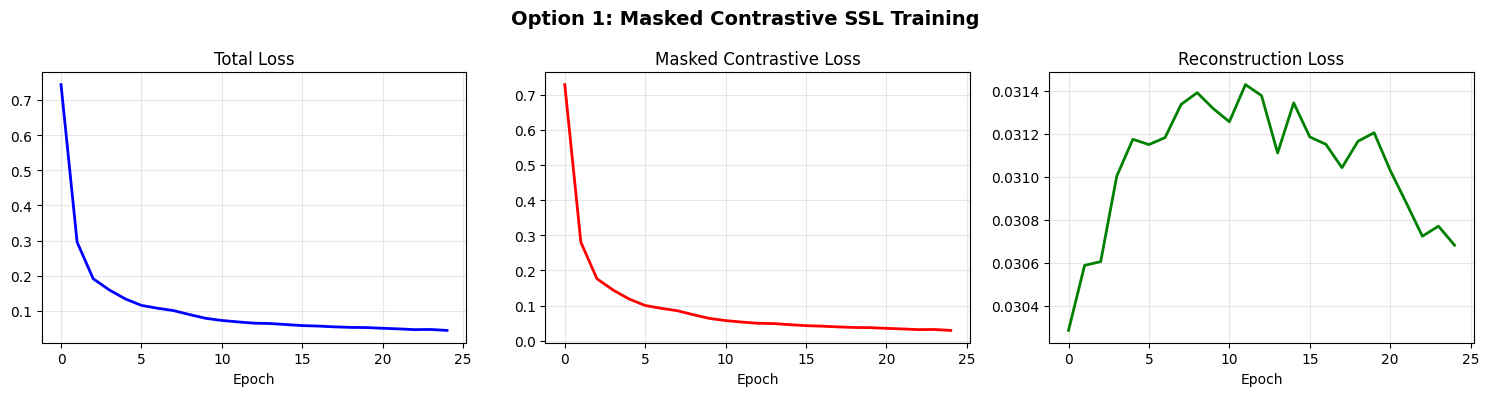

In [ ]:
# ============================================
# 📈 Step 12: Plot SSL Training Curves
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ssl_history['loss'], 'b-', linewidth=2)
axes[0].set_title('Total Loss', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ssl_history['contrastive'], 'r-', linewidth=2)
axes[1].set_title('Masked Contrastive Loss', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ssl_history['reconstruction'], 'g-', linewidth=2)
axes[2].set_title('Reconstruction Loss', fontsize=12)
axes[2].set_xlabel('Epoch')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Option 1: Masked Contrastive SSL Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option1_ssl_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# 💾 Step 13: Save Pretrained Model
# ============================================

torch.save({
    'encoder': encoder.state_dict(),
    'proj_head': proj_head.state_dict(),
    'decoder': decoder.state_dict(),
    'config': {
        'feat_dim': cfg.feat_dim,
        'proj_dim': cfg.proj_dim,
        'mask_weight': cfg.mask_weight
    }
}, 'option1_ssl_pretrained.pth')

print("💾 Pretrained model saved: option1_ssl_pretrained.pth")

💾 Pretrained model saved: option1_ssl_pretrained.pth


In [ ]:
# ============================================
# 🎯 Step 14: Fine-tuning for Classification
# ============================================
# KEY IMPROVEMENTS (inspired by DannyNet SOTA):
# 1. UNFREEZE encoder with differential learning rate
# 2. Use Focal Loss instead of BCE (handles class imbalance better)
# 3. Use AdamW optimizer (better generalization)
# 4. More aggressive LR scheduler (factor=0.1, patience=2)
# ============================================

# ✅ UNFREEZE encoder for fine-tuning (CRITICAL for performance!)
# Use differential learning rate: encoder gets lower LR than classifier
for param in encoder.parameters():
    param.requires_grad = True  # UNFROZEN!
encoder.train()

classifier = Classifier(cfg.feat_dim, len(DISEASE_CATEGORIES)).to(cfg.device)

# ✅ Use Focal Loss (better for imbalanced multi-label classification)
criterion = FocalLoss(alpha=1.0, gamma=2.0)

# ✅ Differential learning rates with AdamW
# Encoder: lower LR (1/10th) since it has good pretrained features
# Classifier: normal LR since it's randomly initialized
encoder_lr = cfg.lr_finetune / 10  # 1e-5 if base is 1e-4
classifier_lr = cfg.lr_finetune    # 1e-4

optimizer_ft = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': encoder_lr},
    {'params': classifier.parameters(), 'lr': classifier_lr}
], weight_decay=1e-4)

# ✅ More aggressive scheduler (like DannyNet)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='max', patience=2, factor=0.1, min_lr=1e-7
)

print("🔧 Fine-tuning Configuration:")
print(f"   ✅ Encoder: UNFROZEN with LR={encoder_lr:.2e}")
print(f"   ✅ Classifier LR: {classifier_lr:.2e}")
print(f"   ✅ Loss: FocalLoss (α=1.0, γ=2.0)")
print(f"   ✅ Optimizer: AdamW")
print(f"   ✅ Scheduler: ReduceLROnPlateau (patience=2, factor=0.1)")

finetune_history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0
FINETUNE_START_EPOCH = 1

if RESUME_FINETUNING:
    if FINETUNE_CHECKPOINT_FILE == "latest":
        ckpt_file = find_latest_checkpoint('option1_finetune')
    else:
        ckpt_file = FINETUNE_CHECKPOINT_FILE
    
    if ckpt_file:
        ft_checkpoint = load_checkpoint(ckpt_file)
        if ft_checkpoint:
            classifier.load_state_dict(ft_checkpoint['classifier'])
            if 'encoder' in ft_checkpoint:
                encoder.load_state_dict(ft_checkpoint['encoder'])
            if 'optimizer' in ft_checkpoint:
                try:
                    optimizer_ft.load_state_dict(ft_checkpoint['optimizer'])
                except:
                    print("⚠️ Optimizer state incompatible, starting fresh")
            finetune_history = ft_checkpoint.get('finetune_history', finetune_history)
            best_val_auc = ft_checkpoint.get('best_val_auc', 0)
            FINETUNE_START_EPOCH = ft_checkpoint['epoch'] + 1
            print(f"🔄 Resuming fine-tuning from epoch {FINETUNE_START_EPOCH}")
    else:
        print("⚠️ RESUME_FINETUNING=True but no checkpoint found. Starting fresh.")

if FINETUNE_START_EPOCH > cfg.finetune_epochs:
    print(f"✅ Fine-tuning already complete ({cfg.finetune_epochs} epochs)")
    print(f"   Best Val AUC: {best_val_auc:.4f}")
else:
    print(f"\n🎯 Starting Fine-tuning (ENCODER UNFROZEN)")
    print(f"   Epochs: {FINETUNE_START_EPOCH} → {cfg.finetune_epochs}")
    print("=" * 50)
    
    SAVE_EVERY_FT = 5
    
    for epoch in range(FINETUNE_START_EPOCH, cfg.finetune_epochs + 1):
        encoder.train()  # Encoder is also training now!
        classifier.train()
        train_loss = 0
        train_preds, train_targets = [], []
        
        loader = tqdm(train_loader, desc=f"Train {epoch}/{cfg.finetune_epochs}") if not IN_KAGGLE else train_loader
        for images, targets in loader:
            images = images.to(cfg.device)
            targets = targets.to(cfg.device)
            
            optimizer_ft.zero_grad()
            
            # ✅ NO torch.no_grad() - encoder is being fine-tuned!
            features = encoder(images)
            logits = classifier(features)
            loss = criterion(logits, targets)
            
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
            
            optimizer_ft.step()
            
            train_loss += loss.item()
            train_preds.append(torch.sigmoid(logits).detach().cpu())
            train_targets.append(targets.cpu())
        
        encoder.eval()
        classifier.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(cfg.device)
                targets = targets.to(cfg.device)
                
                features = encoder(images)
                logits = classifier(features)
                loss = criterion(logits, targets)
                
                val_loss += loss.item()
                val_preds.append(torch.sigmoid(logits).cpu())
                val_targets.append(targets.cpu())
        
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        
        train_auc = np.mean([roc_auc_score(train_targets[:, i], train_preds[:, i]) 
                             for i in range(len(DISEASE_CATEGORIES)) 
                             if len(np.unique(train_targets[:, i])) > 1])
        val_auc = np.mean([roc_auc_score(val_targets[:, i], val_preds[:, i]) 
                           for i in range(len(DISEASE_CATEGORIES)) 
                           if len(np.unique(val_targets[:, i])) > 1])
        
        finetune_history['train_loss'].append(train_loss / len(train_loader))
        finetune_history['train_auc'].append(train_auc)
        finetune_history['val_loss'].append(val_loss / len(val_loader))
        finetune_history['val_auc'].append(val_auc)
        
        scheduler.step(val_auc)
        
        current_lr = optimizer_ft.param_groups[0]['lr']
        print(f"Epoch {epoch}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, LR={current_lr:.2e}")
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            save_checkpoint({
                'encoder': encoder.state_dict(),
                'classifier': classifier.state_dict(),
                'val_auc': val_auc,
                'epoch': epoch,
                'phase': 'best_model'
            }, 'option1_best_model.pth')
            print(f"  ✅ Best model saved! Val AUC: {val_auc:.4f}")
        
        if epoch % SAVE_EVERY_FT == 0 or epoch == cfg.finetune_epochs:
            save_checkpoint({
                'epoch': epoch,
                'encoder': encoder.state_dict(),
                'classifier': classifier.state_dict(),
                'optimizer': optimizer_ft.state_dict(),
                'finetune_history': finetune_history,
                'best_val_auc': best_val_auc,
                'phase': 'finetuning'
            }, 'option1_finetune_latest.pth')
            
            save_checkpoint({
                'epoch': epoch,
                'encoder': encoder.state_dict(),
                'classifier': classifier.state_dict(),
                'finetune_history': finetune_history,
                'best_val_auc': best_val_auc,
                'phase': 'finetuning'
            }, f'option1_finetune_epoch{epoch}.pth')
    
    print(f"\n🏆 Best Validation AUC: {best_val_auc:.4f}")

✅ Loaded: option1_finetune_latest.pth (saved: 2026-01-06 02:27:17)
🔄 Resuming fine-tuning from epoch 61
✅ Fine-tuning already complete (30 epochs)
   Best Val AUC: 0.6849


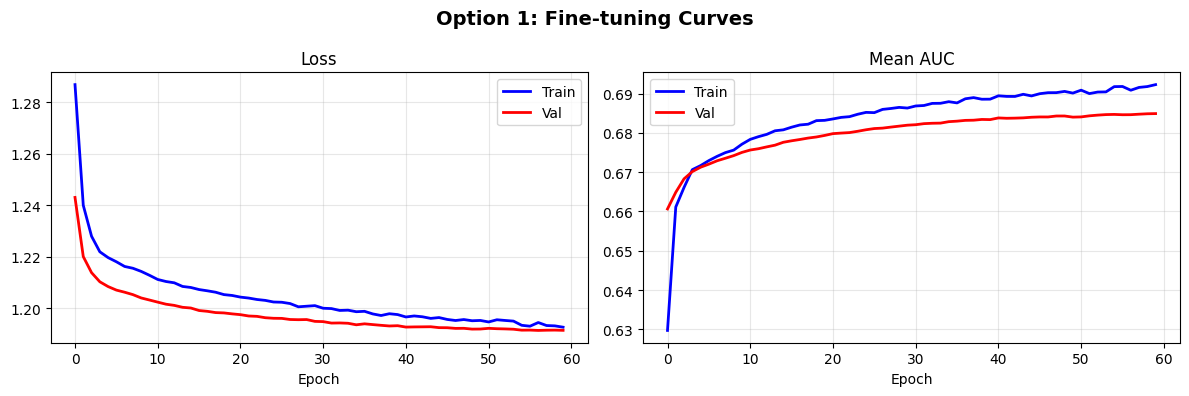

In [ ]:
# ============================================
# 📊 Step 15: Plot Fine-tuning Curves
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(finetune_history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(finetune_history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(finetune_history['train_auc'], 'b-', label='Train', linewidth=2)
axes[1].plot(finetune_history['val_auc'], 'r-', label='Val', linewidth=2)
axes[1].set_title('Mean AUC')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Option 1: Fine-tuning Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option1_finetune_curves.png', dpi=150, bbox_inches='tight')
plt.show()


📊 Per-Disease AUC Scores:
Atelectasis         : 0.7013
Cardiomegaly        : 0.7416
Effusion            : 0.7413
Infiltration        : 0.6364
Mass                : 0.6446
Nodule              : 0.5787
Pneumonia           : 0.6550
Pneumothorax        : 0.6969
Consolidation       : 0.7361
Edema               : 0.7866
Emphysema           : 0.6940
Fibrosis            : 0.6308
Pleural_Thickening  : 0.6735
Hernia              : 0.6717

Mean AUC            : 0.6849



📊 Per-Disease AUC Scores:
Atelectasis         : 0.7013
Cardiomegaly        : 0.7416
Effusion            : 0.7413
Infiltration        : 0.6364
Mass                : 0.6446
Nodule              : 0.5787
Pneumonia           : 0.6550
Pneumothorax        : 0.6969
Consolidation       : 0.7361
Edema               : 0.7866
Emphysema           : 0.6940
Fibrosis            : 0.6308
Pleural_Thickening  : 0.6735
Hernia              : 0.6717

Mean AUC            : 0.6849


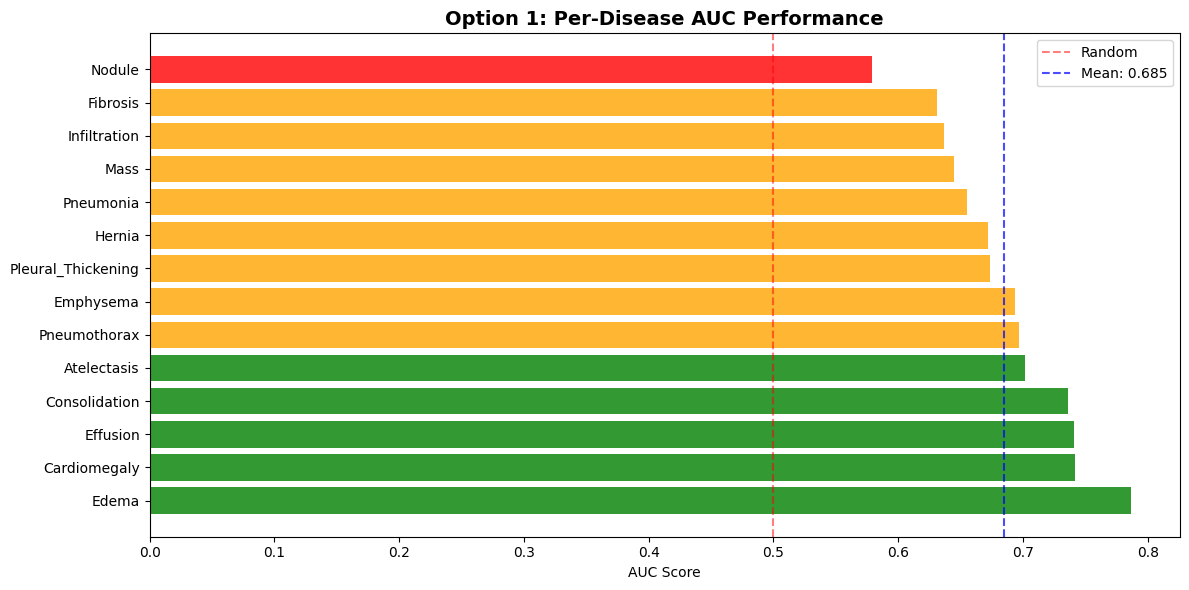

In [ ]:
# ============================================
# 📈 Step 16: Final Evaluation on Validation Set
# ============================================

from sklearn.metrics import f1_score, precision_score, recall_score

# Load best model
best_model_path = os.path.join(CHECKPOINT_DIR, 'option1_best_model.pth')
checkpoint = torch.load(best_model_path, map_location=cfg.device, weights_only=False)
encoder.load_state_dict(checkpoint['encoder'])
classifier.load_state_dict(checkpoint['classifier'])

encoder.eval()
classifier.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    loader = tqdm(val_loader, desc="Evaluating Val") if not IN_KAGGLE else val_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        all_preds.append(torch.sigmoid(logits).cpu())
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Per-disease AUC on Validation
print("\n📊 Validation Set - Per-Disease AUC Scores:")
print("=" * 40)
val_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
        val_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

val_mean_auc = np.mean([a for _, a in val_auc_scores])
print(f"\n{'Val Mean AUC':20s}: {val_mean_auc:.4f}")

# ============================================
# 🎯 Find Optimal Per-Disease Thresholds (like DannyNet)
# ============================================
print("\n" + "="*60)
print("🎯 OPTIMAL THRESHOLD SEARCH (per-disease)")
print("="*60)

optimal_thresholds = {}
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        best_f1 = 0
        best_thresh = 0.5
        
        # Search thresholds from 0.1 to 0.9
        for thresh in np.arange(0.1, 0.9, 0.02):
            preds_binary = (all_preds[:, i] > thresh).astype(int)
            if preds_binary.sum() > 0 and (1 - preds_binary).sum() > 0:
                f1 = f1_score(all_targets[:, i], preds_binary, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh
        
        optimal_thresholds[disease] = best_thresh
        print(f"{disease:20s}: optimal thresh = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# ============================================
# 🧪 Step 17: Test Set Evaluation (Held-Out)
# ============================================

print("\n" + "="*60)
print("🧪 TEST SET EVALUATION (Patient-Level Held-Out)")
print("="*60)

test_preds, test_targets = [], []
with torch.no_grad():
    loader = tqdm(test_loader, desc="Evaluating Test") if not IN_KAGGLE else test_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        test_preds.append(torch.sigmoid(logits).cpu())
        test_targets.append(targets)

test_preds = torch.cat(test_preds).numpy()
test_targets = torch.cat(test_targets).numpy()

# Test AUC with fixed threshold (0.5)
print("\n📊 Test Set - Per-Disease AUC Scores (threshold=0.5):")
print("=" * 40)
test_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        test_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

test_mean_auc = np.mean([a for _, a in test_auc_scores])
print(f"\n{'Test Mean AUC':20s}: {test_mean_auc:.4f}")

# Test with OPTIMAL thresholds
print("\n📊 Test Set - With Optimal Thresholds (from validation):")
print("=" * 60)
print(f"{'Disease':20s} {'AUC':>8s} {'Thresh':>8s} {'F1':>8s} {'Precision':>10s} {'Recall':>8s}")
print("-" * 60)

test_f1_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        thresh = optimal_thresholds.get(disease, 0.5)
        preds_binary = (test_preds[:, i] > thresh).astype(int)
        
        f1 = f1_score(test_targets[:, i], preds_binary, zero_division=0)
        prec = precision_score(test_targets[:, i], preds_binary, zero_division=0)
        rec = recall_score(test_targets[:, i], preds_binary, zero_division=0)
        
        test_f1_scores.append(f1)
        print(f"{disease:20s} {auc:8.4f} {thresh:8.2f} {f1:8.4f} {prec:10.4f} {rec:8.4f}")

print("-" * 60)
print(f"{'MEAN':20s} {test_mean_auc:8.4f} {'--':>8s} {np.mean(test_f1_scores):8.4f}")

# Plot Test AUC bar chart
test_auc_scores.sort(key=lambda x: x[1], reverse=True)
diseases, aucs = zip(*test_auc_scores)

plt.figure(figsize=(12, 6))
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
plt.barh(diseases, aucs, color=colors, alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
plt.axvline(test_mean_auc, color='blue', linestyle='--', alpha=0.7, label=f'Test Mean: {test_mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.title('Option 1: Test Set Per-Disease AUC Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('option1_test_auc_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# 📝 Summary
# ============================================

print("\n" + "=" * 60)
print("📝 OPTION 1: MASKED CONTRASTIVE SSL SUMMARY")
print("=" * 60)
print(f"\nMethod: Rule-Based Lung Segmentation + Per-Sample Weighted Loss")
print(f"\nKey Innovation:")
print(f"  - Otsu + morphology for automatic lung field detection")
print(f"  - Per-sample loss weighting based on segmentation quality")
print(f"  - Higher weight (up to 1.3x) for well-segmented images")
print(f"\nDataset: NIH Chest X-ray 14 (Patient-Level Split)")
print(f"  - Training: {len(train_df):,} images ({len(train_patients):,} patients)")
print(f"  - Validation: {len(val_df):,} images ({len(val_patients):,} patients)")
print(f"  - Test: {len(test_df):,} images ({len(test_patients):,} patients)")
print(f"\nPretraining epochs: {cfg.pretrain_epochs}")
print(f"Fine-tuning epochs: {cfg.finetune_epochs}")
print(f"Mask weight: {cfg.mask_weight}")
print(f"\nResults:")
print(f"  📈 Validation Mean AUC: {val_mean_auc:.4f}")
print(f"  🧪 Test Mean AUC: {test_mean_auc:.4f}")
print("\nFiles saved:")
print("  - option1_ssl_pretrained.pth")
print("  - option1_best_model.pth")
print("  - option1_segmentation_samples.png")
print("  - option1_ssl_curves.png")
print("  - option1_finetune_curves.png")
print("  - option1_test_auc_performance.png")
print("=" * 60)


📝 OPTION 1: MASKED CONTRASTIVE SSL SUMMARY

Method: Rule-Based Lung Segmentation + Per-Sample Weighted Loss

Key Innovation:
  - Otsu + morphology for automatic lung field detection
  - Per-sample loss weighting based on segmentation quality
  - Higher weight (up to 1.3x) for well-segmented images

Dataset: NIH Chest X-ray 14
Training samples: 89,696
Validation samples: 22,424

Pretraining epochs: 25
Fine-tuning epochs: 30
Mask weight: 0.3

🏆 Final Mean AUC: 0.6849

Files saved:
  - option1_ssl_pretrained.pth
  - option1_best_model.pth
  - option1_segmentation_samples.png
  - option1_ssl_curves.png
  - option1_finetune_curves.png
  - option1_auc_performance.png
